<a href="https://colab.research.google.com/github/skywalker0803r/x3d/blob/main/x3d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 定義資料集

Balanced dataset: 326 samples (strike: 163, not strike: 163)
Balanced dataset: 332 samples (strike: 166, not strike: 166)
Balanced dataset: 388 samples (strike: 194, not strike: 194)
📦 訓練資料範例


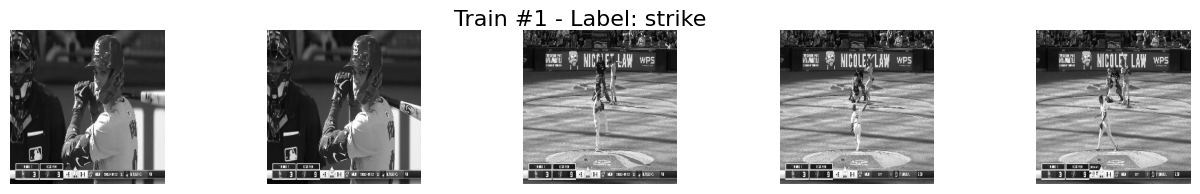

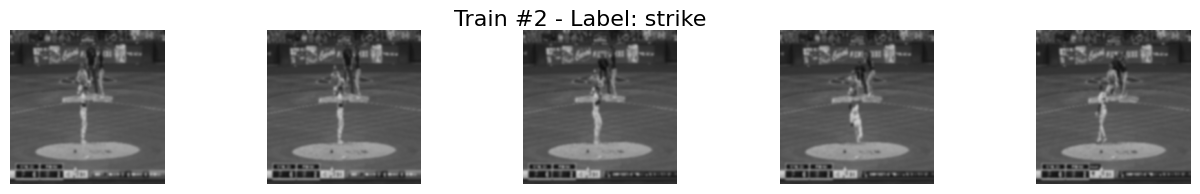

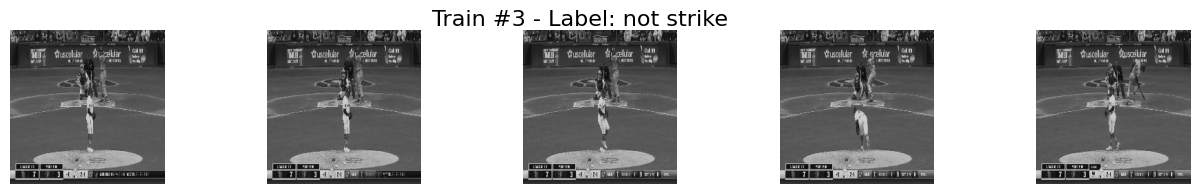

🧪 驗證資料範例


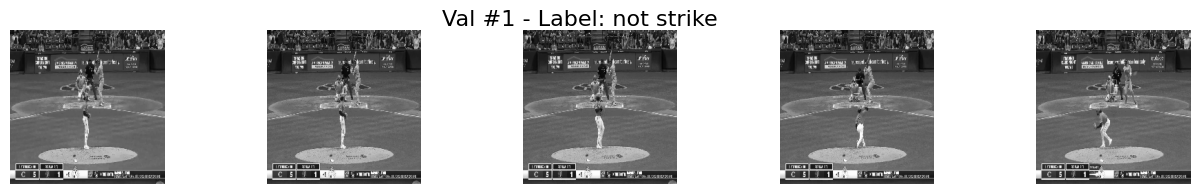

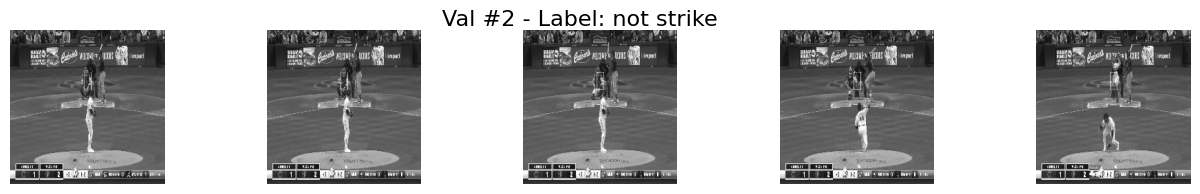

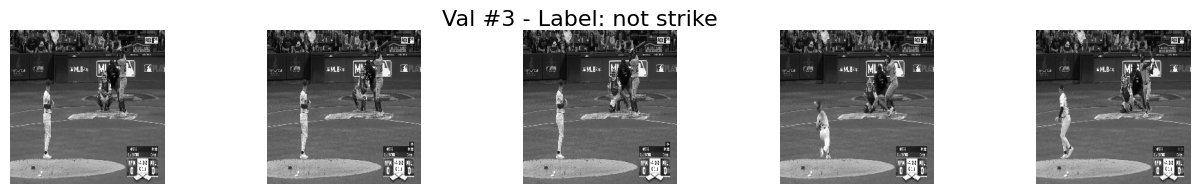

In [13]:
import warnings
warnings.filterwarnings('ignore')
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from pytorchvideo.models.hub import x3d_xs
from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset
import pandas as pd
from torchvision.io import read_video
from torchvision import transforms as T
import cv2
import numpy as np
from torchvision import transforms
import random
from PIL import Image
from torch.utils.data import ConcatDataset
from torch.utils.data import Subset
import copy
from PIL import Image, ImageFilter
import warnings
warnings.filterwarnings('ignore')

def read_video_cv2(path, max_frames=240, sample_frames=120):
    # 開啟影片檔案
    cap = cv2.VideoCapture(path)
    frames = []

    # 逐幀讀取影片直到結束
    while True:
        ret, frame = cap.read()
        if not ret:
            break  # 如果讀不到（影片結束），就跳出
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # BGR轉RGB
        frames.append(frame)

    # 釋放影片資源
    cap.release()

    # 若讀不到任何幀，丟出錯誤
    total_frames = len(frames)
    if total_frames == 0:
        raise RuntimeError(f"Cannot read video {path}")

    # 若影片幀數不足 max_frames，重複最後一幀來補足長度
    while len(frames) < max_frames:
        frames.append(frames[-1].copy())

    # 限制最多只取 max_frames 幀
    frames = frames[:max_frames]

    # 等距地選出 sample_frames 幀索引位置
    indices = np.linspace(0, max_frames - 1, sample_frames).astype(int)

    # 根據索引取出對應的幀
    sampled_frames = [frames[i] for i in indices]

    # 將幀列表轉成 NumPy 陣列 (T, H, W, C)
    video_np = np.stack(sampled_frames, axis=0)

    # 轉成 PyTorch Tensor 並重新排列維度為 (C, T, H, W)
    video_t = torch.from_numpy(video_np).permute(3, 0, 1, 2)

    # 回傳影片張量
    return video_t

# 資料模型
class Normalize(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()  # 繼承自 nn.Module 的初始化
        # 將 mean 轉成張量，並 reshape 成 (C, 1, 1, 1)，方便與 (C, T, H, W) 的影像進行 broadcast
        self.mean = torch.tensor(mean).view(-1, 1, 1, 1)
        # 將 std 轉成張量，並 reshape 成 (C, 1, 1, 1)，方便與影像資料進行除法 broadcast
        self.std = torch.tensor(std).view(-1, 1, 1, 1)

    def forward(self, x):
        # 對輸入張量 x 做標準化：每個 channel 減去平均值、除以標準差
        return (x - self.mean) / self.std


# 🔧 安全資料增強
class SafeVideoAugmentation:
    def __init__(self, resize=(224, 224), apply_blur_prob=0.3, apply_brightness_prob=0.3):
        # 設定每幀影像的 resize 大小
        self.resize = resize

        # 定義將 PIL 影像轉成 tensor 的轉換器 (0~1 範圍)
        self.to_tensor = transforms.ToTensor()

        # 定義應用模糊的機率
        self.apply_blur_prob = apply_blur_prob

        # 定義應用亮度調整的機率
        self.apply_brightness_prob = apply_brightness_prob

        # 定義影片的標準化方式 (使用 ImageNet 標準)
        self.normalize = Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])

    def __call__(self, frames):
        augmented = []  # 用來儲存增強後的每一幀

        # 隨機決定是否對整個影片應用模糊
        apply_blur = random.random() < self.apply_blur_prob

        # 隨機決定是否對整個影片應用亮度調整
        apply_brightness = random.random() < self.apply_brightness_prob

        # 隨機產生一個亮度調整係數 (0.8~1.2 之間)
        brightness_factor = random.uniform(0.8, 1.2)

        # 遍歷每一幀做增強處理
        for frame in frames:
            # 將影像 resize 成固定大小
            frame = cv2.resize(frame, self.resize)

            # 將 NumPy 陣列轉為 PIL 影像，方便後續使用 PIL 的影像增強方法
            pil_frame = Image.fromarray(frame)

            # 若要套用模糊，則加上 GaussianBlur
            if apply_blur:
                pil_frame = pil_frame.filter(ImageFilter.GaussianBlur(radius=1.5))  # radius 控制模糊強度

            # 若要套用亮度調整，則進行亮度增強
            if apply_brightness:
                pil_frame = transforms.functional.adjust_brightness(pil_frame, brightness_factor)

            # ✅ 將彩色影像轉為灰階（單通道）再轉回 RGB（三通道）
            gray_frame = pil_frame.convert("L")         # 轉灰階
            gray_frame = gray_frame.convert("RGB")      # 再轉回 RGB（R=G=B）

            # 將 PIL 影像轉成 tensor，形狀為 (C, H, W)，值在 0~1
            tensor_frame = self.to_tensor(gray_frame)

            # 加入增強後的幀
            augmented.append(tensor_frame)

        # 將所有幀堆疊起來成 (T, C, H, W)
        augmented_tensor = torch.stack(augmented)

        # 將維度轉換成 (C, T, H, W)，符合影片模型輸入格式
        augmented_tensor = augmented_tensor.permute(1, 0, 2, 3)

        # 對整段影片張量做標準化處理
        augmented_tensor = self.normalize(augmented_tensor)

        # 回傳增強與標準化後的影片張量
        return augmented_tensor #我希望將影片轉灰階但是保留通道數

class VideoDataset(Dataset):
    def __init__(self, csv_path, video_dir, original_frames=240, sample_frames=120, transform=None):
        # 儲存影片資料夾路徑
        self.video_dir = video_dir

        # 記錄原始影片長度（最大幀數）
        self.original_frames = original_frames

        # 指定要等距抽樣的幀數（模型輸入長度）
        self.sample_frames = sample_frames

        # 如果沒有指定 transform，就使用自訂的 SafeVideoAugmentation 增強方法
        self.transform = transform or SafeVideoAugmentation()

        # 讀取標註檔 CSV，包含 filename 與 description 欄位
        self.data = pd.read_csv(csv_path)

        # 定義一個內部函數來檢查檔案是否存在
        def file_exists(filename):
            return os.path.isfile(os.path.join(video_dir, filename))

        # 只保留影片檔案存在的資料列
        mask = self.data['filename'].apply(file_exists)
        filtered_data = self.data[mask].reset_index(drop=True)

        # 若有遺失檔案則顯示警告訊息
        num_removed = len(self.data) - len(filtered_data)
        if num_removed > 0:
            print(f"Warning: removed {num_removed} entries because video files not found")
        self.data = filtered_data

        # 根據 description 是否包含 'strike' 來建立 label（strike 為 1，其餘為 0）
        self.data['label'] = self.data['description'].str.contains('strike', case=False).astype(int)

        # === 平衡 strike / not strike 的樣本數 ===
        # 分開兩個類別
        strike_data = self.data[self.data['label'] == 1]
        not_strike_data = self.data[self.data['label'] == 0]

        # 取得兩個類別中樣本數較小的值
        min_len = min(len(strike_data), len(not_strike_data))

        # 從兩類別中各自隨機抽樣 min_len 筆
        strike_sampled = strike_data.sample(min_len, random_state=42)
        not_strike_sampled = not_strike_data.sample(min_len, random_state=42)

        # 合併兩類並打亂順序，重設 index
        self.data = pd.concat([strike_sampled, not_strike_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
        print(f"Balanced dataset: {len(self.data)} samples (strike: {min_len}, not strike: {min_len})")

    def __len__(self):
        # 回傳樣本總數
        return len(self.data)

    def __getitem__(self, idx):
        # 取得第 idx 筆資料的內容
        row = self.data.iloc[idx]

        # 根據檔名組合出完整影片路徑
        video_path = os.path.join(self.video_dir, row['filename'])

        # 取得該筆資料的標籤（0 或 1）
        label = row['label']

        # 讀取影片並進行抽樣（輸出為 (C, T, H, W) 的 tensor）
        video = read_video_cv2(video_path, self.original_frames, self.sample_frames)

        # 將影片張量從 (C, T, H, W) → (T, H, W, C)，以符合 transform 的處理格式（OpenCV 與 PIL 格式）
        video = video.permute(1, 2, 3, 0).numpy()

        # 若有指定 transform，則套用（例如 resize、增強、標準化）
        if self.transform:
            video = self.transform(video)

        # 回傳處理後的影片張量與其標籤
        return video, label

dataset_paths = [
    {
        "csv_path": "/content/drive/MyDrive/Baseball Movies/CH_videos_4s/CH.csv",
        "video_dir": "/content/drive/MyDrive/Baseball Movies/CH_videos_4s"
    },
    {
        "csv_path": "/content/drive/MyDrive/Baseball Movies/FF_videos_4s/FF.csv",
        "video_dir": "/content/drive/MyDrive/Baseball Movies/FF_videos_4s"
    },
    {
        "csv_path": "/content/drive/MyDrive/Baseball Movies/SL_videos_4s/SL.csv",
        "video_dir": "/content/drive/MyDrive/Baseball Movies/SL_videos_4s"
    },
]

datasets = []
for item in dataset_paths:
    dataset = VideoDataset(
        csv_path=item["csv_path"],
        video_dir=item["video_dir"],
        original_frames=240,
        sample_frames=120,
        transform=None  # 先不加 transform，稍後設置
    )
    datasets.append(dataset)

full_dataset = ConcatDataset(datasets)

# 1. 分割 index
val_split = 0.2
dataset_len = len(full_dataset)
indices = list(range(dataset_len))
split = int(val_split * dataset_len)
random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# 2. 建立 train/val dataset，並複製原始 dataset
train_dataset = copy.deepcopy(full_dataset)
val_dataset = copy.deepcopy(full_dataset)

# 3. 設定 transform 分別給 train/val dataset
for d in train_dataset.datasets:
    d.transform = SafeVideoAugmentation()

for d in val_dataset.datasets:
    d.transform = SafeVideoAugmentation(apply_blur_prob=0.0, apply_brightness_prob=0.0)

# 4. 建立 Subset
train_set = Subset(train_dataset, train_indices)
val_set = Subset(val_dataset, val_indices)

# 5. 建立 dataloader
batch_size = 10
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

def denormalize(tensor, mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225]):
    # 還原 Normalize 過的 Tensor
    mean = torch.tensor(mean).view(3, 1, 1, 1)
    std = torch.tensor(std).view(3, 1, 1, 1)
    return tensor * std + mean

# 查看資料集
import matplotlib.pyplot as plt
def show_video_sample(dataset, index, title=""):
    video, label = dataset[index]  # (C, T, H, W)

    # ✅ 還原 Normalize 並限制範圍
    video = denormalize(video).clamp(0, 1)  # 確保值在 [0,1]

    # (C, T, H, W) → (T, H, W, C) for imshow
    video = video.permute(1, 2, 3, 0).cpu().numpy()

    # 取幾幀展示
    num_frames = video.shape[0]
    sample_indices = np.linspace(0, num_frames - 1, 5).astype(int)

    fig, axes = plt.subplots(1, 5, figsize=(16, 2))
    for i, ax in enumerate(axes):
        ax.imshow(video[sample_indices[i]])
        ax.axis("off")
    plt.suptitle(f"{title} - Label: {'strike' if label==1 else 'not strike'}", fontsize=16)
    plt.show()

# 隨機展示幾筆訓練與驗證資料
print("📦 訓練資料範例")
for i in range(3):
    show_video_sample(train_set, random.randint(0, len(train_set) - 1), title=f"Train #{i+1}")

print("🧪 驗證資料範例")
for i in range(3):
    show_video_sample(val_set, random.randint(0, len(val_set) - 1), title=f"Val #{i+1}")


# 定義訓練和驗證函數

In [14]:
# ------- 1. 訓練函數 --------
def train_one_epoch(model, loader, criterion, optimizer, device, scaler):
    model.train()  # 設定模型為訓練模式
    total_loss, correct, total = 0, 0, 0  # 初始化損失總和、正確預測數量、樣本數

    for videos, labels in tqdm(loader, desc="Training", leave=False):  # 迭代訓練資料
        videos, labels = videos.to(device), labels.to(device).long()  # 將資料移動到指定裝置並轉成long型態

        optimizer.zero_grad()  # 清空先前梯度

        with torch.cuda.amp.autocast():  # 混合精度自動運算
            outputs = model(videos)  # 前向傳播，取得預測結果
            loss = criterion(outputs, labels)  # 計算損失值

        scaler.scale(loss).backward()  # 損失反向傳播，梯度縮放
        scaler.step(optimizer)  # 更新權重
        scaler.update()  # 更新縮放比例

        total_loss += loss.item()  # 累加損失
        preds = outputs.argmax(dim=1)  # 取得預測結果中最大機率的類別
        correct += (preds == labels).sum().item()  # 計算正確預測數
        total += labels.size(0)  # 累加樣本數量

    return total_loss / len(loader), correct / total  # 回傳平均損失與準確率

# ------- 2. 驗證函數 --------
def evaluate(model, loader, criterion, device):
    model.eval()  # 設定模型為驗證模式
    total_loss, correct, total = 0, 0, 0  # 初始化損失總和、正確預測數量、樣本數

    with torch.no_grad():  # 關閉梯度計算
        with torch.cuda.amp.autocast():  # 混合精度自動運算
            for videos, labels in tqdm(loader, desc="Validating", leave=False):  # 迭代驗證資料
                videos, labels = videos.to(device), labels.to(device).long()  # 將資料移動到指定裝置並轉成long型態
                outputs = model(videos)  # 前向傳播，取得預測結果
                loss = criterion(outputs, labels)  # 計算損失值

                total_loss += loss.item()  # 累加損失
                preds = outputs.argmax(dim=1)  # 取得預測結果中最大機率的類別
                correct += (preds == labels).sum().item()  # 計算正確預測數
                total += labels.size(0)  # 累加樣本數量

    return total_loss / len(loader), correct / total  # 回傳平均損失與準確率


# 訓練並保存

In [16]:
# ------- 3. 主訓練流程 --------
def main():
    batch_size = 10      # 設定每批次訓練的樣本數量為10
    num_epochs = 2     # 設定訓練的總迭代輪數為20
    original_frames = 240  # 原始影片的幀數
    sample_frames = 120    # 抽樣後使用的幀數
    val_split = 0.2        # 驗證集比例，將20%資料用作驗證
    lr = 1e-4              # 學習率設定為0.0001

    model = x3d_xs(pretrained=True)  # 載入預訓練的X3D XS模型
    model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)  # 修改最後分類層為2分類
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 判斷是否使用GPU，否則用CPU
    model = model.to(device)  # 將模型搬移至指定裝置（GPU或CPU）

    criterion = nn.CrossEntropyLoss()  # 使用交叉熵作為損失函數
    optimizer = optim.Adam(model.parameters(), lr=lr)  # 使用Adam優化器並設定學習率

    scaler = torch.amp.GradScaler('cuda')  # 初始化自動混合精度的梯度縮放器（僅GPU適用）

    best_val_acc = 0  # 初始化最佳驗證準確率為0
    for epoch in range(num_epochs):  # 迴圈跑每一個epoch
        print(f"\nEpoch {epoch+1}/{num_epochs}")  # 印出目前迭代進度

        # 執行單輪訓練，取得訓練損失和準確率
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
        # 執行驗證，取得驗證損失和準確率
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # 印出訓練結果
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        # 印出驗證結果
        print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # 若驗證準確率優於目前最佳值，則儲存模型權重
        if val_acc > best_val_acc:
            best_val_acc = val_acc  # 更新最佳準確率
            save_dir = "/content/drive/MyDrive"  # Google Drive的儲存目錄
            os.makedirs(save_dir, exist_ok=True)  # 若資料夾不存在則建立
            filename = f"epoch_{epoch+1}_valacc_{val_acc:.4f}.pt"  # 動態命名模型檔案名稱
            model_save_path = os.path.join(save_dir, filename)  # 合成完整路徑
            torch.save(model.state_dict(), model_save_path)  # 儲存模型權重
            print(f"✅ Saved best model to Google Drive: {model_save_path}")  # 印出保存成功訊息

if __name__ == "__main__":
    main()  # 執行主函數



Epoch 1/2


Train Loss: 0.6971 | Train Acc: 0.5030
Val   Loss: 0.6950 | Val   Acc: 0.5072
✅ Saved best model to Google Drive: /content/drive/MyDrive/epoch_1_valacc_0.5072.pt

Epoch 2/2


Train Loss: 0.6723 | Train Acc: 0.5806
Val   Loss: 0.7000 | Val   Acc: 0.5215
✅ Saved best model to Google Drive: /content/drive/MyDrive/epoch_2_valacc_0.5215.pt


# 載入保存的模型持續訓練

In [18]:
model_path = '/content/drive/MyDrive/epoch_2_valacc_0.5215.pt'
def main(model_path):
  batch_size = 10      # 設定每批次訓練的樣本數量為10
  num_epochs = 2     # 設定訓練的總迭代輪數為20
  original_frames = 240  # 原始影片的幀數
  sample_frames = 120    # 抽樣後使用的幀數
  val_split = 0.2        # 驗證集比例，將20%資料用作驗證
  lr = 1e-4              # 學習率設定為0.0001

  # 這裡將模型model_path的權重載入
  model = x3d_xs(pretrained=True)  # 載入預訓練的X3D XS模型
  model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)  # 修改最後分類層為2分類
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 判斷是否使用GPU，否則用CPU
  model = model.to(device)  # 將模型搬移至指定裝置（GPU或CPU）
  # 載入已有模型權重
  model.load_state_dict(torch.load(model_path, map_location=device))
  print(f"Model {model_path} weights loaded successfully.")

  criterion = nn.CrossEntropyLoss()  # 使用交叉熵作為損失函數
  optimizer = optim.Adam(model.parameters(), lr=lr)  # 使用Adam優化器並設定學習率

  scaler = torch.amp.GradScaler('cuda')  # 初始化自動混合精度的梯度縮放器（僅GPU適用）

  best_val_acc = 0  # 初始化最佳驗證準確率為0
  for epoch in range(num_epochs):  # 迴圈跑每一個epoch
      print(f"\nEpoch {epoch+1}/{num_epochs}")  # 印出目前迭代進度

      # 執行單輪訓練，取得訓練損失和準確率
      train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
      # 執行驗證，取得驗證損失和準確率
      val_loss, val_acc = evaluate(model, val_loader, criterion, device)

      # 印出訓練結果
      print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
      # 印出驗證結果
      print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

      # 若驗證準確率優於目前最佳值，則儲存模型權重
      if val_acc > best_val_acc:
          best_val_acc = val_acc  # 更新最佳準確率
          save_dir = "/content/drive/MyDrive"  # Google Drive的儲存目錄
          os.makedirs(save_dir, exist_ok=True)  # 若資料夾不存在則建立
          filename = f"epoch_{epoch+1}_valacc_{val_acc:.9f}.pt"  # 動態命名模型檔案名稱
          model_save_path = os.path.join(save_dir, filename)  # 合成完整路徑
          torch.save(model.state_dict(), model_save_path)  # 儲存模型權重
          print(f"✅ Saved best model to Google Drive: {model_save_path}")  # 印出保存成功訊息

if __name__ == "__main__":
    main(model_path)


Model /content/drive/MyDrive/epoch_2_valacc_0.5215.pt weights loaded successfully.

Epoch 1/2


Train Loss: 0.6348 | Train Acc: 0.6476
Val   Loss: 0.7187 | Val   Acc: 0.5407
✅ Saved best model to Google Drive: /content/drive/MyDrive/epoch_1_valacc_0.540669856.pt

Epoch 2/2


Train Loss: 0.5927 | Train Acc: 0.7109
Val   Loss: 0.7449 | Val   Acc: 0.5167


# 繪製混淆矩陣

3it [00:24,  8.32s/it]


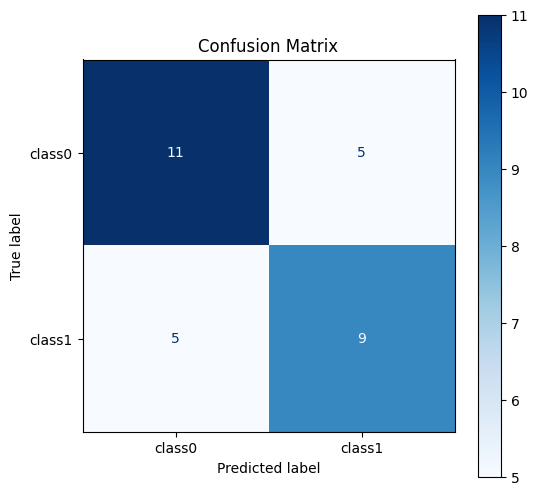

In [22]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice

def predict(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in tqdm(islice(loader, 3)):
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix")
    plt.show()
# 載入模型權重，設定device等

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = x3d_xs(pretrained=True)  # 載入預訓練的X3D XS模型
model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 2)  # 修改最後分類層為2分類
model.load_state_dict(torch.load('/content/drive/MyDrive/epoch_1_valacc_0.540669856.pt', map_location=device))
model.to(device)

# 假設你有val_loader
preds, labels = predict(model, val_loader, device)

# 假設二分類，class_names可自己定義
class_names = ["class0", "class1"]

plot_confusion_matrix(labels, preds, class_names)
